## Import Libraries

In [140]:
import os
import re
import pathlib
import json
import sqlalchemy as db
import requests

from datetime import datetime, date

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from statsmodels.graphics.gofplots import qqplot

import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected=True)


## Configurations

In [141]:
import quandl
import pandas_datareader as pdr
from pycoingecko import CoinGeckoAPI
import yfinance as yf
import twitter

# Quandl API
quandl_key = "f6Y8avFQZwXp37ftC1_6"
quandl.ApiConfig.api_key = quandl_key
cg = CoinGeckoAPI()

# EIA API
eia_key = "320c16a416c0cb06ed1a737576ec3ee0"

# Twitter API
tw_consumer_key = ""
tw_consumer_secret = ""
tw_token = ""
tw_token_secret = ""

#api = twitter.Api(consumer_key=tw_consumer_key,
#                 consumer_secret=tw_consumer_secret,
#                  access_token_key=tw_token,
#                  access_token_secret=tw_token_secret)

twitter_search_url = 'https://twitter.com/search?q=(bitcoin%20OR%20ethereum%20OR%20cryptocurrency)&src=typed_query'
#results = api.GetSearch(twitter_search_url)

project_dir = pathlib.Path().absolute()
workdir = project_dir.parent
# print(f"{project_dir}\n{workdir}")

## Build functions

#### Local Functions for Data manipulation

In [142]:
def check_items(list1, list2):
    check = all(item in list1 for item in list2)
    return check

def value_mapper(df, col_name_to_map, new_col_name, mapping_dict):
    df[new_col_name] = df[col_name_to_map].str.upper().map(mapping_dict)
    return df

def df_subset(df, df_name, mapping_dict):
    columns_mapped = [i for i in mapping_dict[df_name][0]]
    df_subset = df[[column for column in df.columns if column in columns_mapped]]
    return df_subset


def column_rename(df, df_name, mapping_dict):
    df_renamed = df.rename(columns=mapping_dict[df_name][0])
    return df_renamed


def df_date_to_col(df):
    df_new_index = df.reset_index()
    df_date_col = df_new_index.rename(columns={'index': 'Date', 'date': 'Date'})
    return df_date_col


def sql_preprocess(df, df_name, mapping_dict):
    df_sub = df_subset(df, df_name, mapping_dict)
    df_ren = column_rename(df_sub, df_name, mapping_dict)
    df_prep = df_date_to_col(df_ren)
    return df_prep

def load_to_sql(table_name):
    engine = db.create_engine('sqlite:///crypto.db', echo=True)
    meta = db.MetaData(engine)

    with engine.connect() as con:
        df_btc_prep.to_sql(table_name, con=con, if_exists='replace', index=False)
        con.close()

def create_date_table(start='1900-01-01', end='2099-12-31'):
   df = pd.DataFrame({"Date": pd.date_range(start, end)})
   df["Week_day"] = df.Date.dt.day_name()
   df["Day"] = df.Date.dt.day
   df["Month"] = df.Date.dt.month
   df["Week"] = df.Date.dt.isocalendar().week
   df["Quarter"] = df.Date.dt.quarter
   df["Year"] = df.Date.dt.year
   df.insert(0, 'DateID', (df.Year.astype(str) + df.Month.astype(str).str.zfill(2) + df.Day.astype(str).str.zfill(2)).astype(int))
   return df

def calculate_average(row_col):
    return row_col.mean()


#### Data Import functions

In [143]:
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

def get_json_data(data_id, json_path, provider):
    """Download and cache JSON data, return as a dataframe."""
    
    cache_path = f"{workdir}\\02_Resources\{data_id}.json"
    try:        
        f = open(cache_path, 'rb')
        df = pd.read_json(f)   
        print(f"Loaded {cache_path} from cache")
    except (OSError, IOError) as e:
        print(f"Downloading {data_id} from {provider}")
        df = pd.read_json(json_path)
        df.to_json(cache_path)
        print(f"Cached {data_id} at {cache_path}")
    return df



## Quandl Data import
# Bitcoin Charts Exchange Rate Data

def get_quandl_data(quandl_id):
    """" Download quandl data and load to json """
    
    data_id = quandl_id.replace('/', '-')
    provider = "Quandl"
    df = quandl.get(quandl_id, returns="pandas")
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


    
## Yahoo Finance Data import

def get_yfinance_data(ticker, start):
    """" Download yahoo finance data and load to json """
    
    data_id = re.sub(r'\W+', '_', ticker)
    provider = "Yahoo"
    df = yf.download(ticker, start)
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)

## Data Reader Data import

def get_datareader_data(datareader_id, provider):
    """" Download datareader data and load to json """
    data_id = datareader_id
    df = pdr.DataReader(datareader_id, provider)
    if df.shape[0]!=df.index.nunique():
        idx = np.unique(df.index.values, return_index=True)[1]
        df = df.iloc[idx]    
            
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


## Poloniex Data import

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2014-01-01', '%Y-%m-%d') # get data from the start of 2014
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_poloniex_data(poloniex_pair):
    """Retrieve cryptocurrency data from poloniex"""
    
    data_id = poloniex_pair
    provider="Poloniex"
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    df = get_json_data(data_id, json_url, provider)
    df = df.set_index('date')
    return df

## EIA Data import

eia_url = "http://api.eia.gov/series/?api_key={}&series_id={}"

def get_eia_data(eia_id):
    response = requests.get(eia_url.format(eia_key, eia_id))
    df = pd.DataFrame(response.json()['series'][0]['data'])
    df = df.set_index(0).rename_axis('Year').sort_index()
    df = df.rename(columns={1:'CO2_Em'})
    return df


## Data Collection

### Collect Market & Exchange data

In [144]:
# Market (Asset) Data from Coingecko.com

markets_list = cg.get_coins_markets(vs_currency='usd')
market_names = []
for item in markets_list:
    market_names.append(item['name'])
df_cg_markets = pd.DataFrame.from_dict(markets_list)
df_cg_markets.columns = df_cg_markets.columns.str.title()
df_cg_markets.head()

Id Symbol          Name  \
0      bitcoin    btc       Bitcoin   
1     ethereum    eth      Ethereum   
2  binancecoin    bnb  Binance Coin   
3       ripple    xrp           XRP   
4       tether   usdt        Tether   

                                               Image  Current_Price  \
0  https://assets.coingecko.com/coins/images/1/la...   59901.000000   
1  https://assets.coingecko.com/coins/images/279/...    2147.380000   
2  https://assets.coingecko.com/coins/images/825/...     604.660000   
3  https://assets.coingecko.com/coins/images/44/l...       1.380000   
4  https://assets.coingecko.com/coins/images/325/...       0.999723   

      Market_Cap  Market_Cap_Rank  Fully_Diluted_Valuation  Total_Volume  \
0  1120630741713                1             1.259744e+12  5.618217e+10   
1   247725439553                2                      NaN  2.944703e+10   
2    93358961313                3             1.030251e+11  1.044489e+10   
3    63413284094                4                      NaN  1.179325e+10   
4    44549558652                5                      NaN  1.235248e+11   

   High_24H  ...  Total_Supply   Max_Supply       Ath  Ath_Change_Percentage  \
0  61262.00  ...  2.100000e+07   21000000.0  61712.00               -2.79370   
1   2195.22  ...           NaN          NaN   2198.36               -2.38804   
2    610.06  ...  1.705337e+08  170533651.9    610.06               -0.97071   
3      1.41  ...  1.000000e+11          NaN      3.40              -59.41239   
4      1.01  ...  4.456192e+10          NaN      1.32              -24.44063   

                   Ath_Date        Atl  Atl_Change_Percentage  \
0  2021-03-13T20:49:26.606Z  67.810000           8.836588e+04   
1  2021-04-10T04:23:58.850Z   0.432979           4.955044e+05   
2  2021-04-12T09:32:32.635Z   0.039818           1.517149e+06   
3  2018-01-07T00:00:00.000Z   0.002686           5.124935e+04   
4  2018-07-24T00:00:00.000Z   0.572521           7.461762e+01   

                   Atl_Date  \
0  2013-07-06T00:00:00.000Z   
1  2015-10-20T00:00:00.000Z   
2  2017-10-19T00:00:00.000Z   
3  2014-05-22T00:00:00.000Z   
4  2015-03-02T00:00:00.000Z   

                                                 Roi              Last_Updated  
0                                               None  2021-04-12T21:25:12.922Z  
1  {'times': 46.83576509175752, 'currency': 'btc'...  2021-04-12T21:24:15.117Z  
2                                               None  2021-04-12T21:24:09.662Z  
3                                               None  2021-04-12T21:25:14.512Z  
4                                               None  2021-04-12T21:06:59.500Z  

[5 rows x 26 columns]

In [145]:
# Exchange Data from Coingecko.com

exchanges_list = cg.get_exchanges_list()
exchange_names = []
for item in exchanges_list:
    exchange_names.append(item['name'])
df_cg_exchanges = pd.DataFrame.from_dict(exchanges_list)
df_cg_exchanges.columns = df_cg_exchanges.columns.str.title() 
df_cg_exchanges.head()

Id          Name  Year_Established                 Country  \
0     binance       Binance            2017.0          Cayman Islands   
1        gdax  Coinbase Pro            2012.0           United States   
2      kraken        Kraken            2011.0           United States   
3    bitfinex      Bitfinex            2014.0  British Virgin Islands   
4  binance_us    Binance US            2019.0           United States   

  Description                         Url  \
0                https://www.binance.com/   
1                https://www.coinbase.com   
2              https://r.kraken.com/Q1m9x   
3                https://www.bitfinex.com   
4               https://www.binance.us/en   

                                               Image Has_Trading_Incentive  \
0  https://assets.coingecko.com/markets/images/52...                 False   
1  https://assets.coingecko.com/markets/images/23...                 False   
2  https://assets.coingecko.com/markets/images/29...                 False   
3  https://assets.coingecko.com/markets/images/4/...                 False   
4  https://assets.coingecko.com/markets/images/46...                 False   

   Trust_Score  Trust_Score_Rank  Trade_Volume_24H_Btc  \
0           10                 1         654679.617637   
1           10                 2          44141.515340   
2           10                 3          27766.674107   
3           10                 4          17813.645315   
4           10                 5          14222.775622   

   Trade_Volume_24H_Btc_Normalized  
0                    654679.617637  
1                     44141.515340  
2                     27766.674107  
3                     17813.645315  
4                     14222.775622

In [146]:
print(f"No. of Assests:   {len(market_names)}\n" \
      f"No. of Exchanges: {len(exchange_names)}")

No. of Assests:   100
No. of Exchanges: 100


In [147]:
print(df_cg_markets['Symbol'])

0      btc
1      eth
2      bnb
3      xrp
4     usdt
      ... 
95     vgx
96    iost
97     ftm
98     rsr
99     amp
Name: Symbol, Length: 100, dtype: object


In [148]:
print(df_cg_exchanges['Id'])

0        binance
1           gdax
2         kraken
3       bitfinex
4     binance_us
         ...    
95          exmo
96        emirex
97        btcbox
98    coinmargin
99       nominex
Name: Id, Length: 100, dtype: object


### Collect Bitcoin Data from different exchanges from Quandl

In [149]:
# Pull the Bitcoin Data from Quandl
from quandl.errors.quandl_error import NotFoundError

exchanges = df_cg_exchanges['Id'].str.upper()

df_run_all = []
    
for exchange in exchanges:
    exchange_code = f"BCHARTS/{exchange}USD"
   
    try:
        df = get_quandl_data(exchange_code)
        df['Exchange'] = exchange
        df_run_all.append(df)
        
    except NotFoundError as e:
        continue

df_quandl_btc_data = pd.concat(df_run_all)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFINEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITSTAMPUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFLYERUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-CEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-P2PB2BUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-OKCOINUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-ITBITUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-HITBTCUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-EXMOUSD.json from cache


In [150]:
# Rename the columns and sort the data
df_quandl_btc_data.rename(columns={'Volume (BTC)': 'Volume_BTC', 'Volume (Currency)': 'Volume_USD'}, inplace=True)
df_quandl_btc_data.sort_index(inplace=True)
df_quandl_btc_data.tail()

Open      High       Low     Close   Volume_BTC    Volume_USD  \
2021-04-10  58129.02  61222.22  57870.00  59766.93  3917.950817  2.352211e+08   
2021-04-10  58110.00  61207.00  57882.00  59775.60  5891.770009  3.525249e+08   
2021-04-11  59773.19  60679.00  59165.15  60013.04  1785.344971  1.067524e+08   
2021-04-11  59760.90  60652.60  59178.70  60005.00  2485.343632  1.485712e+08   
2021-04-11  59630.80  60500.00  59154.90  59963.20    89.065988  5.315055e+06   

            Weighted Price  Exchange  
2021-04-10    60036.756949  BITSTAMP  
2021-04-10    59833.437890    KRAKEN  
2021-04-11    59793.734228  BITSTAMP  
2021-04-11    59778.931922    KRAKEN  
2021-04-11    59675.471575       CEX

### Collect Bitcoin Data from Poloniex

In [151]:
# Pull the Bitcoin Data from Poloniex, rename columns and sort
df_poloniex_btc_data = get_poloniex_data("USDT_BTC")
df_poloniex_btc_data.columns= df_poloniex_btc_data.columns.str.title()
df_poloniex_btc_data = df_poloniex_btc_data.rename(columns={'Volume': 'Volume_USD', 'Quotevolume': 'Volume_BTC',  
                                                     'Weightedaverage': 'Weighted Price'})

df_poloniex_btc_data['Exchange'] = 'POLONIEX'
column_names_btc=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD', 'Weighted Price', 'Exchange']
df_poloniex_btc_data = df_poloniex_btc_data.reindex(columns=column_names_btc)
df_poloniex_btc_data.sort_index(inplace=True)
df_poloniex_btc_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\USDT_BTC.json from cache


Open          High           Low         Close  \
date                                                                 
2021-04-08  55945.493943  58148.609716  55717.630409  58069.505553   
2021-04-09  58069.000000  58876.918449  57680.000000  58120.315844   
2021-04-10  58128.000000  61246.067767  57885.910800  59780.845701   
2021-04-11  59779.092332  60666.660000  59264.294109  60010.441365   
2021-04-12  60010.441355  61227.566568  59350.282101  60029.315472   

             Volume_BTC    Volume_USD  Weighted Price  Exchange  
date                                                             
2021-04-08   598.845827  3.420324e+07    57115.274667  POLONIEX  
2021-04-09   426.641693  2.483485e+07    58210.088957  POLONIEX  
2021-04-10  1053.898684  6.330361e+07    60066.122555  POLONIEX  
2021-04-11   507.439283  3.034617e+07    59802.556829  POLONIEX  
2021-04-12   766.895812  4.615328e+07    60181.944965  POLONIEX

### Append Poloniex Data to have the consoildated BTC Dataset

In [152]:
# Append the Poloniex Data to Quandl Dataset, in order to have the consolidated Data
df_btc_data = df_quandl_btc_data.append(df_poloniex_btc_data)
df_btc_data.sort_values(by=['Exchange'])
df_btc_data['Market'] = "BTC"
df_btc_data = df_btc_data.sort_index()
df_btc_data.tail()

Open          High           Low         Close  \
2021-04-11  59760.900000  60652.600000  59178.700000  60005.000000   
2021-04-11  59779.092332  60666.660000  59264.294109  60010.441365   
2021-04-11  59773.190000  60679.000000  59165.150000  60013.040000   
2021-04-11  59630.800000  60500.000000  59154.900000  59963.200000   
2021-04-12  60010.441355  61227.566568  59350.282101  60029.315472   

             Volume_BTC    Volume_USD  Weighted Price  Exchange Market  
2021-04-11  2485.343632  1.485712e+08    59778.931922    KRAKEN    BTC  
2021-04-11   507.439283  3.034617e+07    59802.556829  POLONIEX    BTC  
2021-04-11  1785.344971  1.067524e+08    59793.734228  BITSTAMP    BTC  
2021-04-11    89.065988  5.315055e+06    59675.471575       CEX    BTC  
2021-04-12   766.895812  4.615328e+07    60181.944965  POLONIEX    BTC

## Data Ingestion

### Collect Altcoin data from Poloniex 

In [153]:
# Pull the Altcoin Data from Poloniex
altcoins = df_cg_markets['Symbol'].str.upper()
df_run_altcoin_new = []

for altcoin in altcoins:
    coinpair = f"BTC_{altcoin}"
    try:
        df = get_poloniex_data(coinpair)
        df['Market'] = altcoin
        df_run_altcoin_new.append(df)
                
    except ValueError as e:
        continue

df_altcoin_poloniex = pd.concat(df_run_altcoin_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ETH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XRP.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOT.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LINK.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_BCH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_TRX.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOGE.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_WBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_EOS.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XMR.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ATOM.json

In [154]:
# Rename the columns and sort the Data
df_altcoin_poloniex_data = df_altcoin_poloniex.sort_index()
df_altcoin_poloniex_data.columns = df_altcoin_poloniex_data.columns.str.title()
df_altcoin_poloniex_data = df_altcoin_poloniex_data.rename(columns={'Volume': 'Volume_BTC', 'Quotevolume': 'Volume_Market',  
                                                     'Weightedaverage': 'Weighted Price'})

df_altcoin_poloniex_data['Exchange'] = 'POLONIEX'
column_names_altcoin=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Market', 'Weighted Price', 'Exchange', 'Market']
df_altcoin_poloniex_data = df_altcoin_poloniex_data.reindex(columns=column_names_altcoin)

df_altcoin_poloniex_data.tail()

Open          High           Low         Close  \
date                                                                 
2021-04-12  1.169500e-04  1.169500e-04  1.150000e-04  1.156900e-04   
2021-04-12  5.481300e-03  5.723690e-03  5.303600e-03  5.313130e-03   
2021-04-12  3.900100e-04  3.951800e-04  3.552700e-04  3.697000e-04   
2021-04-12  1.782000e-05  1.983000e-05  1.714000e-05  1.801000e-05   
2021-04-12  4.700000e-07  4.900000e-07  4.600000e-07  4.800000e-07   

            Volume_BTC  Volume_Market  Weighted Price  Exchange Market  
date                                                                    
2021-04-12    0.017049     146.693120    1.162200e-04  POLONIEX    BNT  
2021-04-12   30.779045    5601.787182    5.494500e-03  POLONIEX    XMR  
2021-04-12    1.584401    4224.183603    3.750700e-04  POLONIEX   ATOM  
2021-04-12    1.330802   72033.055955    1.847000e-05  POLONIEX   MANA  
2021-04-12    0.046324   97906.975497    4.700000e-07  POLONIEX    AMP

### Inject Other relevant Data

In [155]:
# Get Bitcoin Transaction data from Quandl

df_cost_tran = get_quandl_data('BCHAIN/CPTRA') # Cost per transaction
df_tran_block = get_quandl_data('BCHAIN/NTRBL') # Num of transactions per block
df_num_tran_pop_excl = get_quandl_data('BCHAIN/NTREP') # Num of transactions excluding popular addresses
df_btc_tran = df_cost_tran.merge(df_tran_block['Value'], how='left', left_index=True, right_index=True, 
                                 ).merge(df_num_tran_pop_excl['Value'], how='left', left_index=True, right_index=True)
df_btc_tran = df_btc_tran.rename(columns={'Value_x': 'Cost_per_TR', 'Value_y': 'Num_TR_per_Block', 'Value': 'Num_TR_ex_pop'})
df_btc_tran['Market'] = 'BTC'
df_btc_tran.tail()


Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHAIN-CPTRA.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHAIN-NTRBL.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHAIN-NTREP.json from cache


Cost_per_TR  Num_TR_per_Block  Num_TR_ex_pop Market
2021-04-07   192.020794       2046.617834         316227    BTC
2021-04-08   190.372114       2078.611940         274868    BTC
2021-04-09   191.393851       2136.315789         319653    BTC
2021-04-10   214.295361       1905.006369         293751    BTC
2021-04-11   229.706618       1747.924138         249489    BTC

In [156]:
# Get Commodities, Indices, etc. from Yahoo Finance

tickers = {
    'Oil_Price': 'CL=F',
    'Gold_Price': 'GC=F',
    'SP500': '^GSPC',
    'DJI': '^DJI',
    'Nasdaq': '^IXIC',
    'Tesla': 'TSLA'
}

start_date = '2000-01-01'

asset_list = []

for name, ticker in tickers.items():
    df = get_yfinance_data(ticker, start_date)
    df['Asset'] = name
    df['Symbol'] = re.sub(r'\W+', '', ticker)
    df['Source'] = 'YAHOO'
    asset_list.append(df)
    
df_asset_data = pd.concat(asset_list)
df_asset_data.to_csv('df_asset.csv')
df_asset_data.tail()

[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\CL_F.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\GC_F.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_GSPC.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_DJI.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_IXIC.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\TSLA.json from cache


Open        High         Low       Close   Adj Close  \
2021-04-06  690.299988  696.549988  681.369995  691.619995  691.619995   
2021-04-07  687.000000  691.380005  667.840027  670.969971  670.969971   
2021-04-08  677.380005  689.549988  671.650024  683.799988  683.799988   
2021-04-09  677.770020  680.969971  669.429993  677.020020  677.020020   
2021-04-12  685.700012  704.799927  682.090027  701.979980  701.979980   

              Volume  Asset Symbol Source  
2021-04-06  28271800  Tesla   TSLA  YAHOO  
2021-04-07  26309400  Tesla   TSLA  YAHOO  
2021-04-08  23924300  Tesla   TSLA  YAHOO  
2021-04-09  21402600  Tesla   TSLA  YAHOO  
2021-04-12  28669635  Tesla   TSLA  YAHOO

In [157]:
# Collect Investor sentiment Data from Quandl

aaii = get_quandl_data('AAII/AAII_SENTIMENT')
inv_sentiment = aaii[['Bullish', 'Bearish', 'Bullish 8-Week Mov Avg', 'Bull-Bear Spread']]
inv_sentiment.rename(columns={'Bullish 8-Week Mov Avg':'Bull_MA_8wk'}, inplace=True)
inv_sentiment['Bear_MA_8wk'] = inv_sentiment['Bearish'].rolling(window=8).mean()
inv_sentiment.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\AAII-AAII_SENTIMENT.json from cache


Bullish   Bearish  Bull_MA_8wk  Bull-Bear Spread  Bear_MA_8wk
2021-03-11  0.494118  0.235294     0.443618          0.258824     0.290818
2021-03-18  0.489437  0.235915     0.446673          0.253522     0.277217
2021-03-25  0.509494  0.205696     0.450599          0.303798     0.255039
2021-04-01  0.458333  0.232143     0.451054          0.226190     0.239572
2021-04-08  0.569079  0.203947     0.455664          0.365132     0.232237

In [158]:
# Upsample the data to Daily from Weekly

upsampled = inv_sentiment.resample('D')
df_inv_sentiment = upsampled.interpolate(method='linear')
df_inv_sentiment.tail()

Bullish   Bearish  Bull_MA_8wk  Bull-Bear Spread  Bear_MA_8wk
2021-04-04  0.505796  0.220059     0.453030          0.285737     0.236428
2021-04-05  0.521616  0.216031     0.453688          0.305585     0.235381
2021-04-06  0.537437  0.212003     0.454347          0.325434     0.234333
2021-04-07  0.553258  0.207975     0.455005          0.345283     0.233285
2021-04-08  0.569079  0.203947     0.455664          0.365132     0.232237

In [159]:
# EIA Data

eia_id = 'INTL.4008-8-WORL-MMTCD.A'
df_co2_emmissions = get_eia_data(eia_id)
df_co2_emmissions.tail()

CO2_Em
Year              
2014  35328.511561
2015  35116.199154
2016  34559.643570
2017  35360.995674
2018  36227.769473

## Data Organization

### Create Date Table

In [160]:
# Create Calendar Table
df_dates = create_date_table()
df_dates.set_index('Date', inplace = True)
df_dates.tail()

DateID   Week_day  Day  Month  Week  Quarter  Year
Date                                                            
2099-12-27  20991227     Sunday   27     12    52        4  2099
2099-12-28  20991228     Monday   28     12    53        4  2099
2099-12-29  20991229    Tuesday   29     12    53        4  2099
2099-12-30  20991230  Wednesday   30     12    53        4  2099
2099-12-31  20991231   Thursday   31     12    53        4  2099

### Preprocessing

<p><strong>Relevant Dataframes:</strong></p>
<ul style="line-height:180%">
    <li>BTC Data: df_btc_data</li>
    <li>Altcoin Data: df_altcoin_poloniex_data</li>
    <li>Fin Assets Data: df_asset_data</li>
    <li>Transactions Data: df_btc_tran</li>
    <li>Exchanges Data: df_cg_exchanges</li>
    <li>Markets Data: df_cg_markets</li>
    <li>Investor Sentiment Data: df_inv_sentiment</li>
    <li>CO2 Emmission Data: df_co2_emmissions</li>
    <li>Date Table: df_dates</li>
</ul>

In [179]:
# Create copies of the imported data that is being transformed

df_btc = df_btc_data.copy()
df_altcoin = df_altcoin_poloniex_data.copy()
df_fin_asset = df_asset_data.copy()
df_transactions = df_btc_tran.copy()
df_exchanges = df_cg_exchanges.copy()
df_markets = df_cg_markets.copy()
df_sentiments = df_inv_sentiment.copy()
df_emmissions = df_co2_emmissions.copy()


In [180]:
# Add the Fin Assets Exchange Data to Exchange List 

exchanges_list_cg = pd.unique(df_exchanges['Id'].str.upper())
exchanges_list_cg= np.append(exchanges_list_cg, ['YAHOO'])
exchanges_list_cg.sort()
exchanges_list_cg

print(f"{exchanges_list_cg}")

['AEX' 'ALTERDICE' 'BANCOR' 'BIBOX' 'BIDESK' 'BIGONE' 'BIKI' 'BINANCE'
 'BINANCE_US' 'BITBANK' 'BITCOIN_COM' 'BITFINEX' 'BITFLYER' 'BITFOREX'
 'BITGET' 'BITHUMB' 'BITHUMB_GLOBAL' 'BITKUB' 'BITMART' 'BITMAX'
 'BITOFFER' 'BITOPRO' 'BITPANDA' 'BITRUE' 'BITSO' 'BITSTAMP' 'BITTREX'
 'BIT_Z' 'BKEX' 'BLOCKCHAIN_COM' 'BTCBOX' 'BTCMARKETS' 'BTCTURK' 'BTSE'
 'BW' 'CEX' 'CHANGELLY' 'COINBENE' 'COINCHECK' 'COINEAL' 'COINHE'
 'COINMARGIN' 'COINONE' 'COINSBIT' 'COINTIGER' 'CRYPTOLOGY' 'CRYPTO_COM'
 'DEXTRADE' 'DIGIFINEX' 'EMIREX' 'ETOROX' 'EXMO' 'FATBTC' 'FLOATSV'
 'FTX_SPOT' 'FTX_US' 'GATE' 'GDAX' 'GEMINI' 'GOPAX' 'HITBTC' 'HOO'
 'HOTBIT' 'HUOBI' 'INDEPENDENT_RESERVE' 'INDODAX' 'ITBIT' 'KORBIT'
 'KRAKEN' 'KUCOIN' 'KUNA' 'LATOKEN' 'LBANK' 'LUNO' 'MAX_MAICOIN' 'MDEX'
 'MERCADO_BITCOIN' 'MXC' 'NICE_HASH' 'NOMINEX' 'OCEANEX' 'OKCOIN' 'OKEX'
 'OMGFIN' 'P2PB2B' 'PARIBU' 'PHEMEX' 'POLONIEX' 'PROBIT' 'QUOINE'
 'SUSHISWAP' 'THODEX' 'UNISWAP' 'UPBIT' 'VCC' 'WAZIRX' 'WHITEBIT' 'XT'
 'YAHOO' 'ZAIF' 'ZB']


In [181]:
# Add the Fin Assets Market data to Market List

markets_list_cg = pd.unique(df_markets['Symbol'].str.upper())
add_markets = np.unique(df_fin_asset['Symbol'])
markets_list_cg = np.append(markets_list_cg, add_markets)
markets_list_cg.sort()
markets_list_cg

print(f"{markets_list_cg}")

['AAVE' 'ADA' 'ALGO' 'AMP' 'ANKR' 'AR' 'ATOM' 'AVAX' 'BAT' 'BCH' 'BNB'
 'BNT' 'BSV' 'BTC' 'BTG' 'BTT' 'BUSD' 'CAKE' 'CDAI' 'CEL' 'CETH' 'CHZ'
 'CLF' 'COMP' 'CRO' 'CUSDC' 'DAI' 'DASH' 'DCR' 'DENT' 'DGB' 'DJI' 'DOGE'
 'DOT' 'EGLD' 'ENJ' 'EOS' 'ETC' 'ETH' 'FEI' 'FIL' 'FLOW' 'FTM' 'FTT' 'GCF'
 'GRT' 'GSPC' 'HBAR' 'HBTC' 'HNT' 'HOT' 'HT' 'ICX' 'IOST' 'IXIC' 'KCS'
 'KSM' 'LEO' 'LINK' 'LTC' 'LUNA' 'MANA' 'MATIC' 'MIOTA' 'MKR' 'NEAR' 'NEO'
 'NEXO' 'NPXS' 'OKB' 'OMG' 'OMI' 'ONE' 'ONT' 'PUNDIX' 'QTUM' 'RSR' 'RUNE'
 'RVN' 'SC' 'SNX' 'SOL' 'STX' 'SUSHI' 'THETA' 'TRX' 'TSLA' 'UMA' 'UNI'
 'USDC' 'USDT' 'UST' 'VET' 'VGX' 'WAVES' 'WBTC' 'WIN' 'XEM' 'XLM' 'XMR'
 'XRP' 'XTZ' 'YFI' 'ZEC' 'ZIL' 'ZRX']


In [182]:
# Create ID Columns for Exchanges

exchange_mapping = {}
for exchange_id, exchange_value in enumerate(exchanges_list_cg):
    exchange_mapping.update({exchange_value:exchange_id+1})
    
value_mapper(df_exchanges, 'Id', 'ExchangeID', exchange_mapping)
df_exchanges[['Id', 'Name', 'ExchangeID']].sort_values(by='Name').tail()

Id      Name  ExchangeID
24        zb        ZB         101
75      zaif      Zaif         100
33  bitflyer  bitFlyer          13
36    etorox    eToroX          51
79     itbit     itBit          67

In [183]:
# Create ID Columns for Markets

market_mapping = {}
for market_id, market_value in enumerate(markets_list_cg):
    market_mapping.update({market_value:market_id+1})

value_mapper(df_markets, 'Symbol', 'MarketID', market_mapping)
df_markets[['Id', 'Symbol', 'MarketID']].sort_values(by='Id').tail()

Id Symbol  MarketID
91             wink    win        97
17  wrapped-bitcoin   wbtc        96
75    yearn-finance    yfi       103
56            zcash    zec       104
58          zilliqa    zil       105

In [184]:
# Map the Exchange and Market IDs to the BTC, Altcoin and Fin Asset Data

value_mapper(df_btc, 'Exchange', 'ExchangeID', exchange_mapping)
value_mapper(df_btc, 'Market', 'MarketID', market_mapping)

value_mapper(df_altcoin, 'Exchange', 'ExchangeID', exchange_mapping)
value_mapper(df_altcoin, 'Market', 'MarketID', market_mapping)

value_mapper(df_fin_asset, 'Source', 'ExchangeID', exchange_mapping)
value_mapper(df_fin_asset, 'Symbol', 'MarketID', market_mapping)

value_mapper(df_transactions, 'Market', 'MarketID', market_mapping)


Cost_per_TR  Num_TR_per_Block  Num_TR_ex_pop Market  MarketID
2009-01-02     0.000000          1.000000              1    BTC        14
2009-01-03     0.000000          1.000000              0    BTC        14
2009-01-04     0.000000          1.000000              0    BTC        14
2009-01-05     0.000000          1.000000              0    BTC        14
2009-01-06     0.000000          1.000000              0    BTC        14
...                 ...               ...            ...    ...       ...
2021-04-07   192.020794       2046.617834         316227    BTC        14
2021-04-08   190.372114       2078.611940         274868    BTC        14
2021-04-09   191.393851       2136.315789         319653    BTC        14
2021-04-10   214.295361       1905.006369         293751    BTC        14
2021-04-11   229.706618       1747.924138         249489    BTC        14

[4483 rows x 5 columns]

In [185]:
## Create mapping table of the columns for Preprocessing

# Create dictionary of the dataframes
data_frames = {
    'BTC Data': df_btc,
    'Altcoin Data': df_altcoin,
    'Fin Assets Data': df_fin_asset,
    'Transaction Data': df_transactions,
    'Exchanges Data': df_exchanges,
    'Markets Data': df_markets,
    'Sentiments Data': df_sentiments,
    'Emmissions Data': df_emmissions,
    'Date Table': df_dates
}

# Organize the Dataframe column names and their mapping into a dictionary
data_frames_col_translate = {}
column_list = []
column_map = {}
for df_name, df in data_frames.items():
    column_list.append(
        [{col: col.replace(" ", "") for col in df.columns}]
    )
    for col in column_list:
        data_frames_col_translate[df_name] = col

data_frames_col_translate

{'BTC Data': [{'Open': 'Open',
   'High': 'High',
   'Low': 'Low',
   'Close': 'Close',
   'Volume_BTC': 'Volume_BTC',
   'Volume_USD': 'Volume_USD',
   'Weighted Price': 'WeightedPrice',
   'Exchange': 'Exchange',
   'Market': 'Market',
   'ExchangeID': 'ExchangeID',
   'MarketID': 'MarketID'}],
 'Altcoin Data': [{'Open': 'Open',
   'High': 'High',
   'Low': 'Low',
   'Close': 'Close',
   'Volume_BTC': 'Volume_BTC',
   'Volume_Market': 'Volume_Market',
   'Weighted Price': 'WeightedPrice',
   'Exchange': 'Exchange',
   'Market': 'Market',
   'ExchangeID': 'ExchangeID',
   'MarketID': 'MarketID'}],
 'Fin Assets Data': [{'Open': 'Open',
   'High': 'High',
   'Low': 'Low',
   'Close': 'Close',
   'Adj Close': 'AdjClose',
   'Volume': 'Volume',
   'Asset': 'Asset',
   'Symbol': 'Symbol',
   'Source': 'Source',
   'ExchangeID': 'ExchangeID',
   'MarketID': 'MarketID'}],
 'Transaction Data': [{'Cost_per_TR': 'Cost_per_TR',
   'Num_TR_per_Block': 'Num_TR_per_Block',
   'Num_TR_ex_pop': 'Num_

### Preprocessed Data

In [186]:
# Preprocess Data for SQL DB load

df_btc_prep = sql_preprocess(df_btc, 'BTC Data', data_frames_col_translate)
df_altcoin_prep = sql_preprocess(df_altcoin, 'Altcoin Data', data_frames_col_translate)
df_fin_asset_prep = sql_preprocess(df_fin_asset, 'Fin Assets Data', data_frames_col_translate)
df_mining_prep = sql_preprocess(df_transactions, 'Transaction Data', data_frames_col_translate)
df_exchanges_prep = sql_preprocess(df_exchanges, 'Exchanges Data', data_frames_col_translate)
df_markets_prep = sql_preprocess(df_markets, 'Markets Data', data_frames_col_translate)
df_dates_prep = sql_preprocess(df_dates, 'Date Table', data_frames_col_translate)

# Additional manual preprocessing

df_markets_prep = df_markets_prep.drop('Date', axis=1)
df_exchanges_prep = df_exchanges_prep.drop('Date', axis=1)
df_exchanges_prep['Trading_Inc'] = df_exchanges_prep['Has_Trading_Incentive'].replace({True: 1, False: 0})


In [188]:
# Saving the data into csv Files for external DB load

df_btc_prep.to_csv('btc_dataset_for_DB.csv')
df_altcoin_prep.to_csv('altcoin_dataset_for_DB.csv')
df_fin_asset_prep.to_csv('fin_assets_dataset_for_DB.csv')
df_mining_prep.to_csv('mining_dataset_for_DB.csv')
df_exchanges_prep.to_csv('exchanges_dataset_for_DB.csv')
df_markets_prep.to_csv('markets_dataset_for_DB.csv')
df_dates_prep.to_csv('date_table_for_DB.csv')

## Data Wrangling

### BTC Dataset Preparation using Pandas

#### Slice the Data

In [189]:
btc_data_prepared = df_btc_prep.merge(df_exchanges_prep[['Id', 'ExchangeID']], how='left', 
                                      left_on='ExchangeID', right_on='ExchangeID').drop(columns=['ExchangeID'])
btc_data_prepared['Exchange'] = btc_data_prepared['Id'].str.upper()
btc_data_prepared['Month'] = btc_data_prepared['Date'].dt.month_name()
btc_data_prepared['Year'] = btc_data_prepared['Date'].dt.year
btc_data_prepared = btc_data_prepared[['Date', 'WeightedPrice', 'Volume_BTC', 'Exchange', 'Year', 'Month']]
btc_data_prepared.tail()

Date  WeightedPrice   Volume_BTC  Exchange  Year  Month
16398 2021-04-11   59778.931922  2485.343632    KRAKEN  2021  April
16399 2021-04-11   59802.556829   507.439283  POLONIEX  2021  April
16400 2021-04-11   59793.734228  1785.344971  BITSTAMP  2021  April
16401 2021-04-11   59675.471575    89.065988       CEX  2021  April
16402 2021-04-12   60181.944965   766.895812  POLONIEX  2021  April

#### Check for N/As and zeros

In [190]:
btc_data_prepared.isna().sum()

Date             0
WeightedPrice    0
Volume_BTC       0
Exchange         0
Year             0
Month            0
dtype: int64

In [191]:
btc_data_prepared.loc[(btc_data_prepared==0).any(axis=1)]

Date  WeightedPrice  Volume_BTC  Exchange  Year      Month
17    2011-09-30            0.0         0.0  BITSTAMP  2011  September
18    2011-10-01            0.0         0.0  BITSTAMP  2011    October
19    2011-10-02            0.0         0.0  BITSTAMP  2011    October
32    2011-10-15            0.0         0.0  BITSTAMP  2011    October
33    2011-10-16            0.0         0.0  BITSTAMP  2011    October
...          ...            ...         ...       ...   ...        ...
14215 2019-12-26            0.0         0.0  BITFLYER  2019   December
14224 2019-12-27            0.0         0.0  BITFLYER  2019   December
14227 2019-12-28            0.0         0.0  BITFLYER  2019   December
14233 2019-12-29            0.0         0.0  BITFLYER  2019   December
14236 2019-12-30            0.0         0.0  BITFLYER  2019   December

[432 rows x 6 columns]

In [192]:
btc_data_prepared = btc_data_prepared.replace(0, np.nan)

In [193]:
btc_data_prepared.isna().sum()

Date               0
WeightedPrice    431
Volume_BTC       432
Exchange           0
Year               0
Month              0
dtype: int64

#### Perform imputations

In [194]:
btc_data_prepared['WeightedPrice_filled'] = btc_data_prepared.groupby(['Exchange', 'Year', 'Month'])['WeightedPrice'].transform(
    lambda grp: grp.fillna(np.mean(grp)))

In [195]:
btc_data_prepared['Volume_filled'] = btc_data_prepared.groupby(['Exchange', 'Year', 'Month'])['Volume_BTC'].transform(
    lambda grp: grp.fillna(np.mean(grp)))

In [196]:
btc_data_prepared

Date  WeightedPrice   Volume_BTC  Exchange  Year      Month  \
0     2011-09-13       5.929231    58.371382  BITSTAMP  2011  September   
1     2011-09-14       5.590798    61.145984  BITSTAMP  2011  September   
2     2011-09-15       5.094272    80.140795  BITSTAMP  2011  September   
3     2011-09-16       4.854515    39.914007  BITSTAMP  2011  September   
4     2011-09-17       4.870000     0.300000  BITSTAMP  2011  September   
...          ...            ...          ...       ...   ...        ...   
16398 2021-04-11   59778.931922  2485.343632    KRAKEN  2021      April   
16399 2021-04-11   59802.556829   507.439283  POLONIEX  2021      April   
16400 2021-04-11   59793.734228  1785.344971  BITSTAMP  2021      April   
16401 2021-04-11   59675.471575    89.065988       CEX  2021      April   
16402 2021-04-12   60181.944965   766.895812  POLONIEX  2021      April   

       WeightedPrice_filled  Volume_filled  
0                  5.929231      58.371382  
1                  5.590798      61.145984  
2                  5.094272      80.140795  
3                  4.854515      39.914007  
4                  4.870000       0.300000  
...                     ...            ...  
16398          59778.931922    2485.343632  
16399          59802.556829     507.439283  
16400          59793.734228    1785.344971  
16401          59675.471575      89.065988  
16402          60181.944965     766.895812  

[16403 rows x 8 columns]

#### Transorm / Aggregate Data

In [197]:
btc_data_prepared = btc_data_prepared.groupby(['Date'], as_index=False).agg({'WeightedPrice_filled':'mean', 
                                                                             'Volume_filled': 'sum'})

In [198]:
btc_data_prepared.isna().sum()

Date                    0
WeightedPrice_filled    0
Volume_filled           0
dtype: int64

In [199]:
# Simple 30-Day Moving Average

btc_data_prepared['SMA_30'] = btc_data_prepared.loc[:,'WeightedPrice_filled'].rolling(window=30).mean().fillna(method='bfill')

In [200]:
# Exponential Moving Average

btc_data_prepared['EMA'] = btc_data_prepared.loc[:,'WeightedPrice_filled'].ewm(span=40, adjust=False).mean()

In [201]:
btc_data_prepared.set_index('Date', inplace=True)

In [202]:
## Bitcoin Dataset prepared
btc_data_prepared

WeightedPrice_filled  Volume_filled        SMA_30           EMA
Date                                                                       
2011-09-13              5.929231      58.371382      4.970674      5.929231
2011-09-14              5.590798      61.145984      4.970674      5.912722
2011-09-15              5.094272      80.140795      4.970674      5.872797
2011-09-16              4.854515      39.914007      4.970674      5.823125
2011-09-17              4.870000       0.300000      4.970674      5.776631
...                          ...            ...           ...           ...
2021-04-08          57192.275974    7771.038425  57034.884225  54658.731905
2021-04-09          58233.119641    6253.975866  57121.089798  54833.092283
2021-04-10          59993.981260   11055.681140  57239.836434  55084.842965
2021-04-11          59762.673638    4867.193874  57343.137537  55313.029827
2021-04-12          60181.944965     766.895812  57366.272775  55550.537882

[3500 rows x 4 columns]

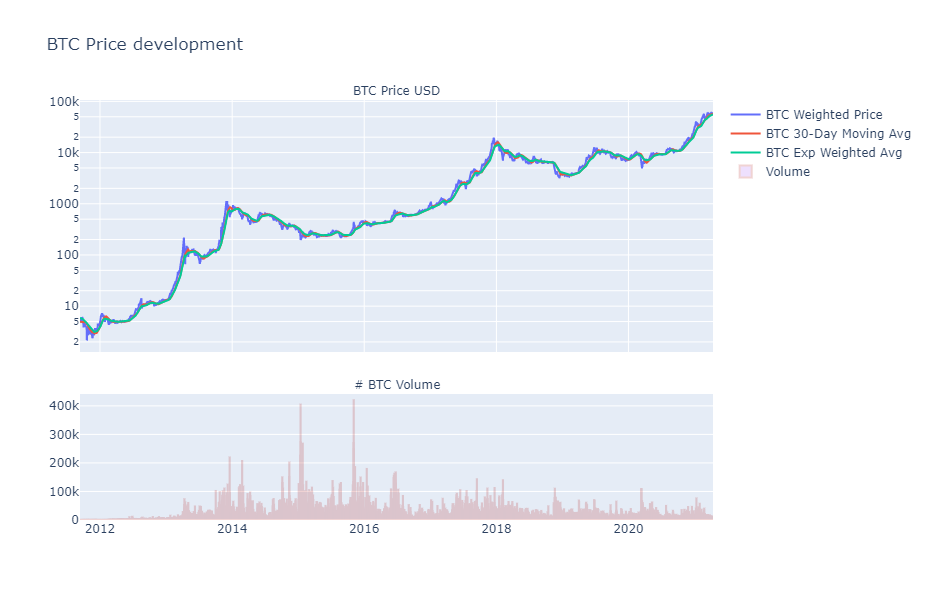

In [203]:
fig = go.Figure()

date = btc_data_prepared.index
price = btc_data_prepared['WeightedPrice_filled']
volume = btc_data_prepared['Volume_filled']
ma = btc_data_prepared['SMA_30']
ema = btc_data_prepared['EMA']


fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.1, subplot_titles=('BTC Price USD', '# BTC Volume'),
                   row_width=[0.5, 1])

fig.add_trace(go.Scatter(x=date, y=price,
                    mode='lines',
                    name='BTC Weighted Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=date, y=ma,
                    mode='lines',
                    name='BTC 30-Day Moving Avg'), row=1, col=1)

fig.add_trace(go.Scatter(x=date, y=ema,
                    mode='lines',
                    name='BTC Exp Weighted Avg'), row=1, col=1)

fig.add_trace(go.Bar(x=date, y=volume,
                     name='Volume',
                     opacity=0.2,
                     marker=dict(
                         line=dict(color='firebrick', width=2)
                     )), row=2, col=1)

fig.update_annotations(font_size=12)

title = "BTC Price development"
                              
fig.update_layout(title=title,
                  dragmode='select',
                  width=1000,
                  height=600,
                  hovermode='closest',
                  yaxis_type='log'
                 )


fig.show()

### Altcoin Dataset Preparation using Pandas

#### Slice the Data

In [205]:
df_altcoin_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35964 entries, 0 to 35963
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           35964 non-null  datetime64[ns]
 1   Open           35964 non-null  float64       
 2   High           35964 non-null  float64       
 3   Low            35964 non-null  float64       
 4   Close          35964 non-null  float64       
 5   Volume_BTC     35964 non-null  float64       
 6   Volume_Market  35964 non-null  float64       
 7   WeightedPrice  35964 non-null  float64       
 8   Exchange       35964 non-null  object        
 9   Market         35964 non-null  object        
 10  ExchangeID     35964 non-null  int64         
 11  MarketID       35964 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 3.3+ MB


In [206]:
altcoin_data_prepared = df_altcoin_prep.merge(df_markets_prep[['Symbol', 'MarketID']], how='left', 
                                      left_on='MarketID', right_on='MarketID').drop(columns=['MarketID'])
altcoin_data_prepared['Symbol'] = altcoin_data_prepared['Symbol'].str.upper()
altcoin_data_prepared['Month'] = altcoin_data_prepared['Date'].dt.month_name()
altcoin_data_prepared['Year'] = altcoin_data_prepared['Date'].dt.year
altcoin_data_prepared_copy = altcoin_data_prepared.copy()
altcoin_data_prepared = altcoin_data_prepared[['Date', 'WeightedPrice', 'Symbol', 'Year', 'Month']]
altcoin_data_prepared.tail()

Date  WeightedPrice Symbol  Year  Month
35959 2021-04-12   1.162200e-04    BNT  2021  April
35960 2021-04-12   5.494500e-03    XMR  2021  April
35961 2021-04-12   3.750700e-04   ATOM  2021  April
35962 2021-04-12   1.847000e-05   MANA  2021  April
35963 2021-04-12   4.700000e-07    AMP  2021  April

#### Check for N/As and zeros

In [207]:
altcoin_data_prepared.isna().sum()

Date             0
WeightedPrice    0
Symbol           0
Year             0
Month            0
dtype: int64

In [208]:
altcoin_data_prepared.loc[(altcoin_data_prepared==0).any(axis=1)]

Empty DataFrame
Columns: [Date, WeightedPrice, Symbol, Year, Month]
Index: []

#### Transorm / Aggregate Data

In [211]:
altcoin_data_grouped = altcoin_data_prepared.groupby(['Date'], as_index=False).agg({'WeightedPrice':'mean'})
altcoin_data_grouped.set_index('Date', inplace=True)

#### Merge Bitcoin and Altcoin Data

In [212]:
altcoin_data_grouped = altcoin_data_grouped.merge(btc_data_prepared['WeightedPrice_filled'], how='left',
                                                   left_index=True, right_index=True)

In [213]:
altcoin_data_grouped['WeightedPrice_USD'] = altcoin_data_grouped['WeightedPrice'] * altcoin_data_grouped['WeightedPrice_filled']

In [214]:
altcoin_data_grouped.drop(columns=['WeightedPrice', 'WeightedPrice_filled'], inplace=True)

In [215]:
# Exponential Moving Average

altcoin_data_grouped['Altcoin_EMA'] = altcoin_data_grouped.loc[:,'WeightedPrice_USD'].ewm(span=40, adjust=False).mean()

In [216]:
btc_altcoin_merged = btc_data_prepared.merge(altcoin_data_grouped['Altcoin_EMA'], how='left', left_index=True, right_index=True)

#### Perform imputations

In [217]:
btc_altcoin_merged.isna().sum()

WeightedPrice_filled      0
Volume_filled             0
SMA_30                    0
EMA                       0
Altcoin_EMA             858
dtype: int64

In [218]:
btc_altcoin_merged[btc_altcoin_merged['Altcoin_EMA'].isna()]

WeightedPrice_filled  Volume_filled      SMA_30         EMA  \
Date                                                                      
2011-09-13              5.929231      58.371382    4.970674    5.929231   
2011-09-14              5.590798      61.145984    4.970674    5.912722   
2011-09-15              5.094272      80.140795    4.970674    5.872797   
2011-09-16              4.854515      39.914007    4.970674    5.823125   
2011-09-17              4.870000       0.300000    4.970674    5.776631   
...                          ...            ...         ...         ...   
2014-01-13            828.504180   33492.930224  751.668283  770.331718   
2014-01-14            828.538510   14314.196240  751.063957  773.171074   
2014-01-15            839.828909   19570.904358  753.989895  776.422675   
2014-01-16            833.925840   12948.094555  758.937783  779.227708   
2014-01-17            801.690400   28283.996629  767.497209  780.323449   

            Altcoin_EMA  
Date                     
2011-09-13          NaN  
2011-09-14          NaN  
2011-09-15          NaN  
2011-09-16          NaN  
2011-09-17          NaN  
...                 ...  
2014-01-13          NaN  
2014-01-14          NaN  
2014-01-15          NaN  
2014-01-16          NaN  
2014-01-17          NaN  

[858 rows x 5 columns]

In [219]:
btc_altcoin_merged['Altcoin_EMA_filled'] = btc_altcoin_merged['Altcoin_EMA'].fillna(
    value=btc_altcoin_merged['Altcoin_EMA'].rolling(window=30, center=True, min_periods=2).mean())

In [220]:
btc_altcoin_merged.isna().sum()

WeightedPrice_filled      0
Volume_filled             0
SMA_30                    0
EMA                       0
Altcoin_EMA             858
Altcoin_EMA_filled      845
dtype: int64

In [221]:
## Check for the missing values in the Altcoin EMA
btc_altcoin_merged.head(850)

WeightedPrice_filled  Volume_filled      SMA_30         EMA  \
Date                                                                      
2011-09-13              5.929231      58.371382    4.970674    5.929231   
2011-09-14              5.590798      61.145984    4.970674    5.912722   
2011-09-15              5.094272      80.140795    4.970674    5.872797   
2011-09-16              4.854515      39.914007    4.970674    5.823125   
2011-09-17              4.870000       0.300000    4.970674    5.776631   
...                          ...            ...         ...         ...   
2014-01-05            875.455969   45162.832295  750.762993  728.931939   
2014-01-06            936.596268   51376.529373  758.079654  739.061906   
2014-01-07            859.785532   63925.712454  762.664528  744.950863   
2014-01-08            821.643821   45099.601243  760.751355  748.691983   
2014-01-09            819.404772   42003.092178  756.121957  752.141387   

            Altcoin_EMA  Altcoin_EMA_filled  
Date                                         
2011-09-13          NaN                 NaN  
2011-09-14          NaN                 NaN  
2011-09-15          NaN                 NaN  
2011-09-16          NaN                 NaN  
2011-09-17          NaN                 NaN  
...                 ...                 ...  
2014-01-05          NaN           22.772790  
2014-01-06          NaN           22.789424  
2014-01-07          NaN           22.661675  
2014-01-08          NaN           22.480622  
2014-01-09          NaN           22.277016  

[850 rows x 6 columns]

In [222]:
## Drop observations before 2014
btc_altcoin_prepared = btc_altcoin_merged[btc_altcoin_merged.index>='2014-01-05']

In [223]:
btc_altcoin_prepared.drop('Altcoin_EMA', axis=1, inplace=True)

In [224]:
btc_altcoin_prepared.rename(columns={'WeightedPrice_filled': 'WeightedPrice', 'Volume_filled': 'Volume', 
                                     'EMA': 'EMA_40', 'Altcoin_EMA_filled': 'Altcoin_EMA_40'}, inplace=True)

In [229]:
btc_altcoin_prepared.isna().sum()

WeightedPrice     0
Volume            0
SMA_30            0
EMA_40            0
Altcoin_EMA_40    0
dtype: int64

In [230]:
## Merged Bitcoin dataset with aggregate Altcoin Prices
btc_altcoin_prepared.tail()

WeightedPrice        Volume        SMA_30        EMA_40  \
Date                                                                  
2021-04-08   57192.275974   7771.038425  57034.884225  54658.731905   
2021-04-09   58233.119641   6253.975866  57121.089798  54833.092283   
2021-04-10   59993.981260  11055.681140  57239.836434  55084.842965   
2021-04-11   59762.673638   4867.193874  57343.137537  55313.029827   
2021-04-12   60181.944965    766.895812  57366.272775  55550.537882   

            Altcoin_EMA_40  
Date                        
2021-04-08     2002.361746  
2021-04-09     2006.950977  
2021-04-10     2014.394534  
2021-04-11     2021.227913  
2021-04-12     2029.046531

### Add Features to the Bitcoin Dataset

In [231]:
altcoin_data_prepared_copy.tail()

Date          Open          High           Low         Close  \
35959 2021-04-12  1.169500e-04  1.169500e-04  1.150000e-04  1.156900e-04   
35960 2021-04-12  5.481300e-03  5.723690e-03  5.303600e-03  5.313130e-03   
35961 2021-04-12  3.900100e-04  3.951800e-04  3.552700e-04  3.697000e-04   
35962 2021-04-12  1.782000e-05  1.983000e-05  1.714000e-05  1.801000e-05   
35963 2021-04-12  4.700000e-07  4.900000e-07  4.600000e-07  4.800000e-07   

       Volume_BTC  Volume_Market  WeightedPrice  Exchange Market  ExchangeID  \
35959    0.017049     146.693120   1.162200e-04  POLONIEX    BNT          88   
35960   30.779045    5601.787182   5.494500e-03  POLONIEX    XMR          88   
35961    1.584401    4224.183603   3.750700e-04  POLONIEX   ATOM          88   
35962    1.330802   72033.055955   1.847000e-05  POLONIEX   MANA          88   
35963    0.046324   97906.975497   4.700000e-07  POLONIEX    AMP          88   

      Symbol  Month  Year  
35959    BNT  April  2021  
35960    XMR  April  2021  
35961   ATOM  April  2021  
35962   MANA  April  2021  
35963    AMP  April  2021

In [232]:
altcoin_data_prepared_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35964 entries, 0 to 35963
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           35964 non-null  datetime64[ns]
 1   Open           35964 non-null  float64       
 2   High           35964 non-null  float64       
 3   Low            35964 non-null  float64       
 4   Close          35964 non-null  float64       
 5   Volume_BTC     35964 non-null  float64       
 6   Volume_Market  35964 non-null  float64       
 7   WeightedPrice  35964 non-null  float64       
 8   Exchange       35964 non-null  object        
 9   Market         35964 non-null  object        
 10  ExchangeID     35964 non-null  int64         
 11  Symbol         35964 non-null  object        
 12  Month          35964 non-null  object        
 13  Year           35964 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(4)
memory usage: 4.

#### Pivot out the top10 Altcoin prices and add as features to the Bitcoin Dataset

In [233]:
altcoin_for_top10 = altcoin_data_prepared.merge(altcoin_data_prepared_copy[['Date', 'Symbol', 'Volume_BTC']], 
                                                left_on=['Date', 'Symbol'], right_on=['Date', 'Symbol'])

In [234]:
top10_altcoin = pd.DataFrame(altcoin_for_top10.groupby('Symbol')['Volume_BTC'].sum().nlargest(10))

In [235]:
top10 = top10_altcoin.reset_index()['Symbol']

In [236]:
altcoin_data_to_merge = altcoin_data_prepared.loc[altcoin_data_prepared['Symbol'].isin(top10)]

In [237]:
altcoin_data_to_merge.set_index('Date', inplace=True)

In [239]:
altcoin_data_to_merge = altcoin_data_to_merge.merge(btc_data_prepared['WeightedPrice_filled'], 
                                                    how='left', left_index=True, right_index=True)

In [240]:
altcoin_data_to_merge['WeightedPrice_USD'] = altcoin_data_to_merge['WeightedPrice'] * altcoin_data_to_merge['WeightedPrice_filled']

In [241]:
altcoin_data_to_pivot = altcoin_data_to_merge[['WeightedPrice_USD', 'Symbol']]

In [242]:
altcoin_data_to_pivot

WeightedPrice_USD Symbol
Date                                
2014-01-18          22.759824    LTC
2014-01-19          23.291456    LTC
2014-01-20          23.542913    LTC
2014-01-21           0.001847   DOGE
2014-01-21          23.328709    LTC
...                       ...    ...
2021-04-12        2145.665078    ETH
2021-04-12           1.364927    XRP
2021-04-12         249.302503    LTC
2021-04-12           0.071617   DOGE
2021-04-12         330.669697    XMR

[22548 rows x 2 columns]

In [243]:
altcoin_data_to_pivot.isna().sum()

WeightedPrice_USD    0
Symbol               0
dtype: int64

In [244]:
altcoin_data_pivoted = altcoin_data_to_pivot.pivot_table('WeightedPrice_USD', ['Date'], 'Symbol')

In [245]:
altcoin_data_pivoted

Symbol            DASH      DOGE        ETC          ETH         LTC  \
Date                                                                   
2014-01-18         NaN       NaN        NaN          NaN   22.759824   
2014-01-19         NaN       NaN        NaN          NaN   23.291456   
2014-01-20         NaN       NaN        NaN          NaN   23.542913   
2014-01-21         NaN  0.001847        NaN          NaN   23.328709   
2014-01-22         NaN  0.001882        NaN          NaN   23.152198   
...                ...       ...        ...          ...         ...   
2021-04-08  259.214840  0.060624  17.250334  2027.145335  223.951798   
2021-04-09  268.826209  0.061727  17.662105  2071.290339  225.155445   
2021-04-10  277.270584  0.062394  18.025192  2145.089000  235.140410   
2021-04-11  285.997860  0.072910  18.786994  2142.499021  253.046515   
2021-04-12  286.476891  0.071617  17.899916  2145.665078  249.302503   

Symbol            SC       XEM         XMR       XRP         ZEC  
Date                                                              
2014-01-18       NaN       NaN         NaN       NaN         NaN  
2014-01-19       NaN       NaN         NaN       NaN         NaN  
2014-01-20       NaN       NaN         NaN       NaN         NaN  
2014-01-21       NaN       NaN         NaN       NaN         NaN  
2014-01-22       NaN       NaN         NaN       NaN         NaN  
...              ...       ...         ...       ...         ...  
2021-04-08  0.028024  0.402062  264.256911  0.980848  178.792777  
2021-04-09  0.029117  0.408796  278.710116  1.034220  191.938692  
2021-04-10  0.028197  0.412159  290.045702  1.230477  202.499485  
2021-04-11  0.026893  0.436865  313.213184  1.393666  219.863291  
2021-04-12  0.026480  0.421875  330.669697  1.364927  224.556891  

[2642 rows x 10 columns]

### Perform imputations on the pivoted dataset

In [246]:
altcoin_data_pivoted['Year'] = altcoin_data_pivoted.index.year
altcoin_data_pivoted['Month'] = altcoin_data_pivoted.index.month_name()

In [247]:
altcoin_data_pivoted.isna().sum()

Symbol
DASH       20
DOGE        3
ETC       918
ETH       567
LTC         0
SC        584
XEM       437
XMR       121
XRP       208
ZEC      1014
Year        0
Month       0
dtype: int64

In [249]:
# Fill the NaN with the mean price per year & month

years = list(set(altcoin_data_pivoted['Year']))
months = list(set(altcoin_data_pivoted['Month']))

for year in years:
    for month in months:
        for col in altcoin_data_pivoted.columns[:10]:
            altcoin_data_pivoted[col].fillna(altcoin_data_pivoted[col][(altcoin_data_pivoted['Year']==year) & (altcoin_data_pivoted['Month']==month)].mean(), inplace=True)

In [250]:
altcoin_data_pivoted

Symbol            DASH      DOGE        ETC          ETH         LTC  \
Date                                                                   
2014-01-18    3.880205  0.000191   1.002188     1.500898   22.759824   
2014-01-19    3.880205  0.000191   1.002188     1.500898   23.291456   
2014-01-20    3.880205  0.000191   1.002188     1.500898   23.542913   
2014-01-21    3.880205  0.001847   1.002188     1.500898   23.328709   
2014-01-22    3.880205  0.001882   1.002188     1.500898   23.152198   
...                ...       ...        ...          ...         ...   
2021-04-08  259.214840  0.060624  17.250334  2027.145335  223.951798   
2021-04-09  268.826209  0.061727  17.662105  2071.290339  225.155445   
2021-04-10  277.270584  0.062394  18.025192  2145.089000  235.140410   
2021-04-11  285.997860  0.072910  18.786994  2142.499021  253.046515   
2021-04-12  286.476891  0.071617  17.899916  2145.665078  249.302503   

Symbol            SC       XEM         XMR       XRP         ZEC  Year  \
Date                                                                     
2014-01-18  0.000020  0.000326    0.521762  0.005760   48.096759  2014   
2014-01-19  0.000020  0.000326    0.521762  0.005760   48.096759  2014   
2014-01-20  0.000020  0.000326    0.521762  0.005760   48.096759  2014   
2014-01-21  0.000020  0.000326    0.521762  0.005760   48.096759  2014   
2014-01-22  0.000020  0.000326    0.521762  0.005760   48.096759  2014   
...              ...       ...         ...       ...         ...   ...   
2021-04-08  0.028024  0.402062  264.256911  0.980848  178.792777  2021   
2021-04-09  0.029117  0.408796  278.710116  1.034220  191.938692  2021   
2021-04-10  0.028197  0.412159  290.045702  1.230477  202.499485  2021   
2021-04-11  0.026893  0.436865  313.213184  1.393666  219.863291  2021   
2021-04-12  0.026480  0.421875  330.669697  1.364927  224.556891  2021   

Symbol        Month  
Date                 
2014-01-18  January  
2014-01-19  January  
2014-01-20  January  
2014-01-21  January  
2014-01-22  January  
...             ...  
2021-04-08    April  
2021-04-09    April  
2021-04-10    April  
2021-04-11    April  
2021-04-12    April  

[2642 rows x 12 columns]

In [251]:
altcoin_data_pivoted.isna().sum()

Symbol
DASH     0
DOGE     0
ETC      0
ETH      0
LTC      0
SC       0
XEM      0
XMR      0
XRP      0
ZEC      0
Year     0
Month    0
dtype: int64

#### Merge the pivoted dataset to the bitcoin dataset

In [252]:
btc_dataset_merged = btc_altcoin_prepared.merge(altcoin_data_pivoted, how='left', left_index=True, right_index=True)

In [253]:
btc_altcoin_dataset_final = btc_dataset_merged.drop(['Year', 'Month'], axis=1)
btc_altcoin_dataset_final['Day_of_Week'] = btc_altcoin_dataset_final.index.day_name()

In [254]:
btc_altcoin_dataset_final

WeightedPrice        Volume        SMA_30        EMA_40  \
Date                                                                  
2014-01-05     875.455969  45162.832295    750.762993    728.931939   
2014-01-06     936.596268  51376.529373    758.079654    739.061906   
2014-01-07     859.785532  63925.712454    762.664528    744.950863   
2014-01-08     821.643821  45099.601243    760.751355    748.691983   
2014-01-09     819.404772  42003.092178    756.121957    752.141387   
...                   ...           ...           ...           ...   
2021-04-08   57192.275974   7771.038425  57034.884225  54658.731905   
2021-04-09   58233.119641   6253.975866  57121.089798  54833.092283   
2021-04-10   59993.981260  11055.681140  57239.836434  55084.842965   
2021-04-11   59762.673638   4867.193874  57343.137537  55313.029827   
2021-04-12   60181.944965    766.895812  57366.272775  55550.537882   

            Altcoin_EMA_40        DASH      DOGE        ETC          ETH  \
Date                                                                       
2014-01-05       22.772790         NaN       NaN        NaN          NaN   
2014-01-06       22.789424         NaN       NaN        NaN          NaN   
2014-01-07       22.661675         NaN       NaN        NaN          NaN   
2014-01-08       22.480622         NaN       NaN        NaN          NaN   
2014-01-09       22.277016         NaN       NaN        NaN          NaN   
...                    ...         ...       ...        ...          ...   
2021-04-08     2002.361746  259.214840  0.060624  17.250334  2027.145335   
2021-04-09     2006.950977  268.826209  0.061727  17.662105  2071.290339   
2021-04-10     2014.394534  277.270584  0.062394  18.025192  2145.089000   
2021-04-11     2021.227913  285.997860  0.072910  18.786994  2142.499021   
2021-04-12     2029.046531  286.476891  0.071617  17.899916  2145.665078   

                   LTC        SC       XEM         XMR       XRP         ZEC  \
Date                                                                           
2014-01-05         NaN       NaN       NaN         NaN       NaN         NaN   
2014-01-06         NaN       NaN       NaN         NaN       NaN         NaN   
2014-01-07         NaN       NaN       NaN         NaN       NaN         NaN   
2014-01-08         NaN       NaN       NaN         NaN       NaN         NaN   
2014-01-09         NaN       NaN       NaN         NaN       NaN         NaN   
...                ...       ...       ...         ...       ...         ...   
2021-04-08  223.951798  0.028024  0.402062  264.256911  0.980848  178.792777   
2021-04-09  225.155445  0.029117  0.408796  278.710116  1.034220  191.938692   
2021-04-10  235.140410  0.028197  0.412159  290.045702  1.230477  202.499485   
2021-04-11  253.046515  0.026893  0.436865  313.213184  1.393666  219.863291   
2021-04-12  249.302503  0.026480  0.421875  330.669697  1.364927  224.556891   

           Day_of_Week  
Date                    
2014-01-05      Sunday  
2014-01-06      Monday  
2014-01-07     Tuesday  
2014-01-08   Wednesday  
2014-01-09    Thursday  
...                ...  
2021-04-08    Thursday  
2021-04-09      Friday  
2021-04-10    Saturday  
2021-04-11      Sunday  
2021-04-12      Monday  

[2655 rows x 16 columns]

#### Check for N/As and zeros after the merge and perform imputations

In [255]:
btc_altcoin_dataset_final.isna().sum()

WeightedPrice      0
Volume             0
SMA_30             0
EMA_40             0
Altcoin_EMA_40     0
DASH              13
DOGE              13
ETC               13
ETH               13
LTC               13
SC                13
XEM               13
XMR               13
XRP               13
ZEC               13
Day_of_Week        0
dtype: int64

In [256]:
btc_altcoin_dataset_final.loc[(btc_altcoin_dataset_final==0).any(axis=1)]

Empty DataFrame
Columns: [WeightedPrice, Volume, SMA_30, EMA_40, Altcoin_EMA_40, DASH, DOGE, ETC, ETH, LTC, SC, XEM, XMR, XRP, ZEC, Day_of_Week]
Index: []

In [257]:
btc_altcoin_dataset_cleansed = btc_altcoin_dataset_final.dropna()

In [258]:
btc_altcoin_dataset_cleansed.isna().sum()

WeightedPrice     0
Volume            0
SMA_30            0
EMA_40            0
Altcoin_EMA_40    0
DASH              0
DOGE              0
ETC               0
ETH               0
LTC               0
SC                0
XEM               0
XMR               0
XRP               0
ZEC               0
Day_of_Week       0
dtype: int64

In [259]:
btc_altcoin_dataset_cleansed.tail()

WeightedPrice        Volume        SMA_30        EMA_40  \
Date                                                                  
2021-04-08   57192.275974   7771.038425  57034.884225  54658.731905   
2021-04-09   58233.119641   6253.975866  57121.089798  54833.092283   
2021-04-10   59993.981260  11055.681140  57239.836434  55084.842965   
2021-04-11   59762.673638   4867.193874  57343.137537  55313.029827   
2021-04-12   60181.944965    766.895812  57366.272775  55550.537882   

            Altcoin_EMA_40        DASH      DOGE        ETC          ETH  \
Date                                                                       
2021-04-08     2002.361746  259.214840  0.060624  17.250334  2027.145335   
2021-04-09     2006.950977  268.826209  0.061727  17.662105  2071.290339   
2021-04-10     2014.394534  277.270584  0.062394  18.025192  2145.089000   
2021-04-11     2021.227913  285.997860  0.072910  18.786994  2142.499021   
2021-04-12     2029.046531  286.476891  0.071617  17.899916  2145.665078   

                   LTC        SC       XEM         XMR       XRP         ZEC  \
Date                                                                           
2021-04-08  223.951798  0.028024  0.402062  264.256911  0.980848  178.792777   
2021-04-09  225.155445  0.029117  0.408796  278.710116  1.034220  191.938692   
2021-04-10  235.140410  0.028197  0.412159  290.045702  1.230477  202.499485   
2021-04-11  253.046515  0.026893  0.436865  313.213184  1.393666  219.863291   
2021-04-12  249.302503  0.026480  0.421875  330.669697  1.364927  224.556891   

           Day_of_Week  
Date                    
2021-04-08    Thursday  
2021-04-09      Friday  
2021-04-10    Saturday  
2021-04-11      Sunday  
2021-04-12      Monday

#### Save the final Dataset

In [260]:
btc_altcoin_dataset_cleansed.to_csv('btc_altcoin_dataset_cleansed.csv')

In [261]:
df_check = pd.read_csv('btc_altcoin_dataset_cleansed.csv')
df_check.tail()

Date  WeightedPrice        Volume        SMA_30        EMA_40  \
2637  2021-04-08   57192.275974   7771.038425  57034.884225  54658.731905   
2638  2021-04-09   58233.119641   6253.975866  57121.089798  54833.092283   
2639  2021-04-10   59993.981260  11055.681140  57239.836434  55084.842965   
2640  2021-04-11   59762.673638   4867.193874  57343.137537  55313.029827   
2641  2021-04-12   60181.944965    766.895812  57366.272775  55550.537882   

      Altcoin_EMA_40        DASH      DOGE        ETC          ETH  \
2637     2002.361746  259.214840  0.060624  17.250334  2027.145335   
2638     2006.950977  268.826209  0.061727  17.662105  2071.290339   
2639     2014.394534  277.270584  0.062394  18.025192  2145.089000   
2640     2021.227913  285.997860  0.072910  18.786994  2142.499021   
2641     2029.046531  286.476891  0.071617  17.899916  2145.665078   

             LTC        SC       XEM         XMR       XRP         ZEC  \
2637  223.951798  0.028024  0.402062  264.256911  0.980848  178.792777   
2638  225.155445  0.029117  0.408796  278.710116  1.034220  191.938692   
2639  235.140410  0.028197  0.412159  290.045702  1.230477  202.499485   
2640  253.046515  0.026893  0.436865  313.213184  1.393666  219.863291   
2641  249.302503  0.026480  0.421875  330.669697  1.364927  224.556891   

     Day_of_Week  
2637    Thursday  
2638      Friday  
2639    Saturday  
2640      Sunday  
2641      Monday

## EDA on the prepared dataset

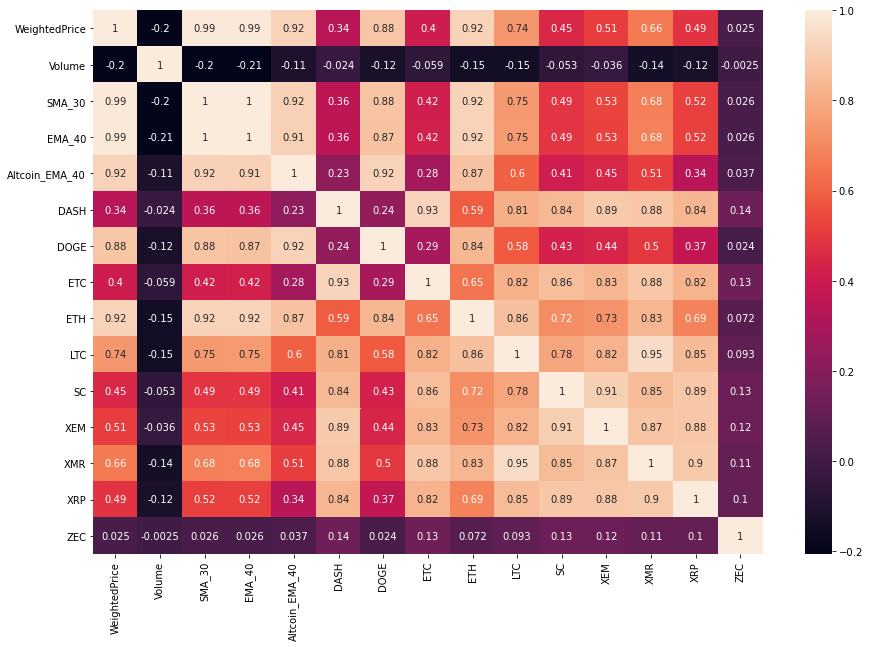

In [266]:
fix, ax = plt.subplots(figsize=(15,10))
_ax = sns.heatmap(btc_altcoin_dataset_cleansed.corr(), annot=True)
plt.show()

### Pairplots

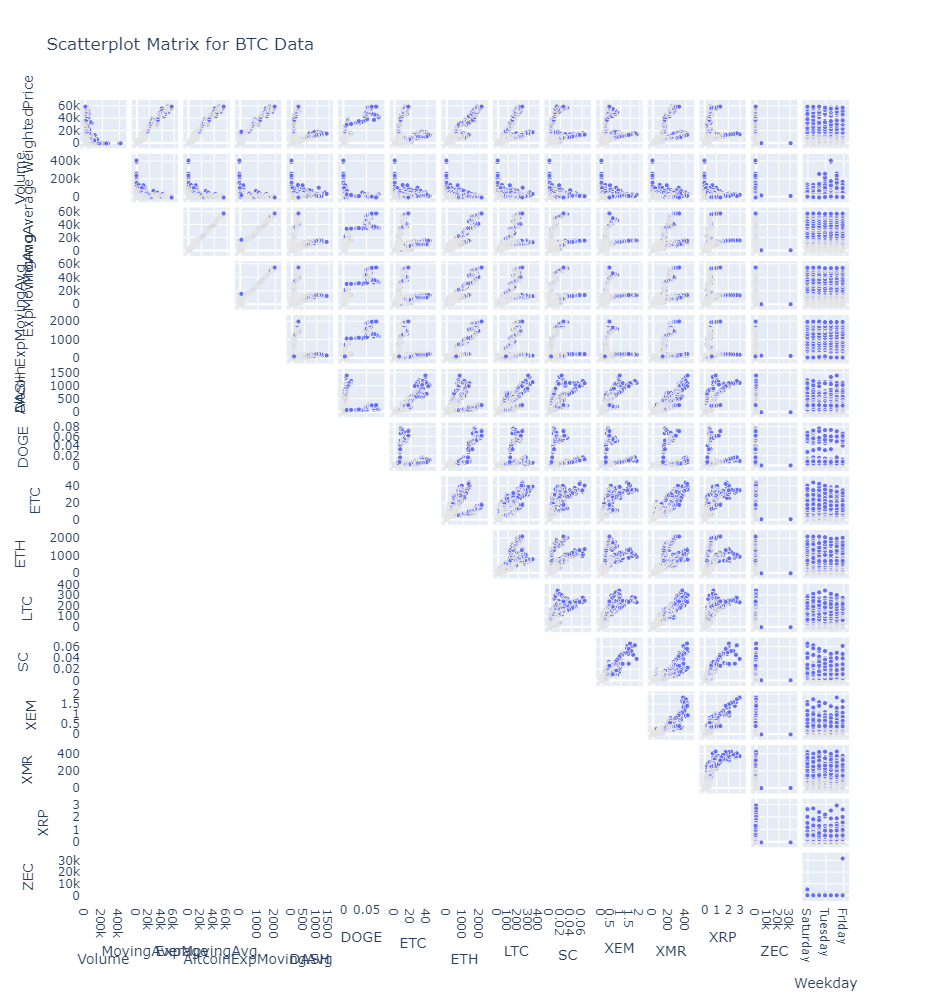

In [262]:
fig = go.Figure()

fig = go.Figure(data=go.Splom(
                  dimensions=[dict(label='WeightedPrice', values=btc_altcoin_dataset_cleansed['WeightedPrice']),
                              dict(label='Volume', values=btc_altcoin_dataset_cleansed['Volume']),
                              dict(label='MovingAverage', values=btc_altcoin_dataset_cleansed['SMA_30']),
                              dict(label='ExpMovingAvg', values=btc_altcoin_dataset_cleansed['EMA_40']),
                              dict(label='AltcoinExpMovingAvg', values=btc_altcoin_dataset_cleansed['Altcoin_EMA_40']),
                              dict(label='DASH', values=btc_altcoin_dataset_cleansed['DASH']),
                              dict(label='DOGE', values=btc_altcoin_dataset_cleansed['DOGE']),
                              dict(label='ETC', values=btc_altcoin_dataset_cleansed['ETC']),
                              dict(label='ETH', values=btc_altcoin_dataset_cleansed['ETH']),
                              dict(label='LTC', values=btc_altcoin_dataset_cleansed['LTC']),
                              dict(label='SC', values=btc_altcoin_dataset_cleansed['SC']),
                              dict(label='XEM', values=btc_altcoin_dataset_cleansed['XEM']),
                              dict(label='XMR', values=btc_altcoin_dataset_cleansed['XMR']),
                              dict(label='XRP', values=btc_altcoin_dataset_cleansed['XRP']),
                              dict(label='ZEC', values=btc_altcoin_dataset_cleansed['ZEC']),
                              dict(label='Weekday', values=btc_altcoin_dataset_cleansed['Day_of_Week'])
                             ],
                              
                  marker=dict(size=5,
                              colorscale='Bluered',
                              line=dict(width=0.5,
                                        color='rgb(230,230,230)')),
                  diagonal=dict(visible=False)))

title = "Scatterplot Matrix for BTC Data"
                              
fig.update_layout(title=title,
                  dragmode='select',
                  width=1000,
                  height=1000,
                  hovermode='closest')

fig.update_traces(showlowerhalf=False)

fig.show()

In [ ]:
sns.pairplot(btc_altcoin_dataset_cleansed, diag_kind='kde', corner=True)

### Hypothesis Testing

In [ ]:
btc_altcoin_OLS = btc_altcoin_prepared[['WeightedPrice', 'Altcoin_EMA_40']].reset_index().drop('Date', axis=1)

In [ ]:
btc_altcoin_OLS

In [ ]:
btc_altcoin_OLS.describe()

In [ ]:
btc_altcoin_OLS_pc = btc_altcoin_OLS.pct_change()

In [ ]:
np.isfinite(btc_altcoin_OLS_pc)

In [ ]:
btc_altcoin_OLS_pc.isna().sum()

In [ ]:
btc_altcoin_OLS_pc.dropna(inplace=True)

In [ ]:
qqplot(btc_altcoin_OLS_pc['WeightedPrice'], line='s')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(btc_altcoin_OLS_pc['Altcoin_EMA_40'],
                                                    btc_altcoin_OLS_pc['WeightedPrice'],
                                                    test_size=0.2, random_state=12)

In [ ]:
X = btc_altcoin_OLS['Altcoin_EMA_40']
X = sm.add_constant(X)
Y = btc_altcoin_OLS['WeightedPrice']

In [ ]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

In [ ]:
print_model = model.summary()
print(print_model)

#### Interpretation

<ul>
    <li>Adj R-square: good model fit</li>
    <li>Constant: Independent Average price of BTC over 7 Years</li>
    <li>Std error: high level of accuracy</li>
    <li>p-value: Model is statistically significant</li>
    <li>Durbin-Watson test: a positive autocorrelation is present, eg a EMA of the Altcoins yesterday is indicating a greater likelihood in BTC price increase in the future</li>
    
    
</ul>